# Auto Encoder

オートエンコーダ。

入力したものをそのまま出力するようなニューラルネットワーク。  
**encoder**と**decoder**の2つの部分からなる。

- encoder：入力を低次元のベクトルに変換する
- decoder：encoderの出力を元の次元に戻す

低次元に圧縮したベクトルを潜在変数と呼ぶ。

<br>

ここではノーマルなオートエンコーダを実装する

活用例
- ノイズ削除
- 次元削減
- 異常検知

<br>

MNISTを使って、何ができるか試してみる

In [1]:
import torch
from torch import nn, optim
import torchvision
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from IPython.display import display
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [2]:
mnist = datasets.MNIST(
    root='./data',
    train=True,
    download=True,
    transform=transforms.ToTensor()
)

dataloader = DataLoader(mnist, batch_size=64, shuffle=True)

def write(model, n_images, dataloader, width=512):
    model.eval()
    with torch.no_grad():
        x, _ = next(iter(dataloader))
        x = x.view(x.size(0), -1)[:n_images].to(device)
        y = model(x)
    x = x.view(n_images, 1, 28, 28).cpu()
    y = y.view(n_images, 1, 28, 28).cpu()
    f = width // n_images
    x = transforms.Resize((f))(x)
    y = transforms.Resize((f))(y)
    grid = torchvision.utils.make_grid(torch.cat([x, y], dim=0), nrow=n_images)
    img = transforms.functional.to_pil_image(grid)
    display(img)

## モデル用意

`z_dim`: 潜在変数の次元数

In [3]:
class AutoEncoder(nn.Module):
    def __init__(self, z_dim):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Linear(784, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, z_dim),
        )
        self.decoder = nn.Sequential(
            nn.Linear(z_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 256),
            nn.ReLU(),
            nn.Linear(256, 784),
            nn.Sigmoid(),
        )

    def forward(self, x):
        z = self.encoder(x)
        y = self.decoder(z)
        return y

学習  
入力と出力の平均二乗誤差を損失とする

In [4]:
def train(model, n_epochs, dataloader, critetion, optimizer):
    model.train()
    for epoch in range(n_epochs):
        for x, _ in dataloader:
            optimizer.zero_grad()
            x = x.view(x.size(0), -1).to(device)
            y = model(x)
            loss = critetion(y, x)
            loss.backward()
            optimizer.step()
        print(f'{epoch+1:>3}epoch, loss:{loss.item()}')

In [5]:
z_dim = 10
ae = AutoEncoder(z_dim).to(device)

n_epochs = 5
critetion = nn.MSELoss()
optimizer = optim.Adam(ae.parameters(), lr=1e-3)

train(ae, n_epochs, dataloader, critetion, optimizer)

  1epoch, loss:0.020836567506194115
  2epoch, loss:0.018389984965324402
  3epoch, loss:0.016705814749002457
  4epoch, loss:0.01618719846010208
  5epoch, loss:0.017844971269369125


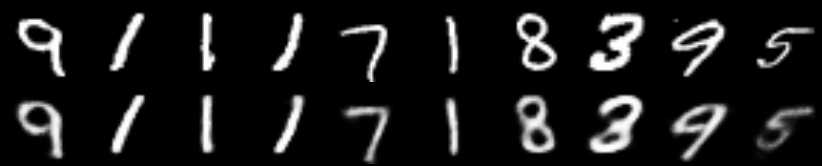

In [6]:
write(ae, 10, dataloader, width=800)

上が入力、下が出力。

### ノイズ削除

一度低次元に圧縮することで情報量が減るため、ノイズ削除に使える。  
上の例にもある通り、下の方がぼやけているのが分かる。

潜在変数の次元数を減らすと、もっとぼやける

  1epoch, loss:0.04408174380660057
  2epoch, loss:0.03638917952775955
  3epoch, loss:0.04576873779296875
  4epoch, loss:0.03473395109176636
  5epoch, loss:0.03621850535273552


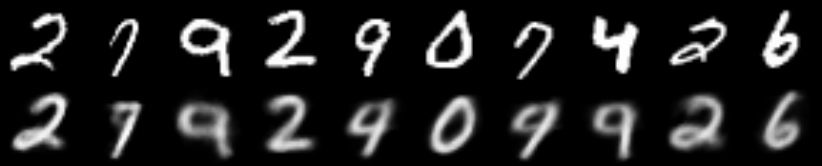

In [7]:
# 2に減らす
z_dim = 2

ae = AutoEncoder(z_dim).to(device)
n_epochs = 5
critetion = nn.MSELoss()
optimizer = optim.Adam(ae.parameters(), lr=1e-3)
train(ae, n_epochs, dataloader, critetion, optimizer)
write(ae, 10, dataloader, width=800)

### 次元削減

encoderは入力を低次元に圧縮しているので、そこだけ使えば次元削減ができる。

↑で学習したencoderを使って、二次元の潜在変数をプロットする。

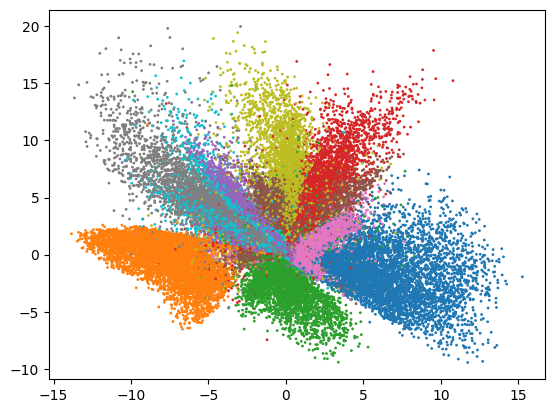

In [8]:
images = []
labels = []
ae.eval()
with torch.no_grad():
    for x, label in dataloader:
        x = x.view(x.size(0), -1).to(device)
        z = ae.encoder(x)
        images.append(z.cpu())
        labels.append(label)
images = torch.cat(images, dim=0)
labels = torch.cat(labels, dim=0)
plt.scatter(images[:, 0], images[:, 1], c=labels, s=1, cmap='tab10');

数字ごとに特徴が表れているのが分かる

<br>

ここである疑問。学習させる必要はあるのか。

別に学習させなくても、入力に対して毎回同じ処理をするので、↑みたいに綺麗に次元削減できるのではないか

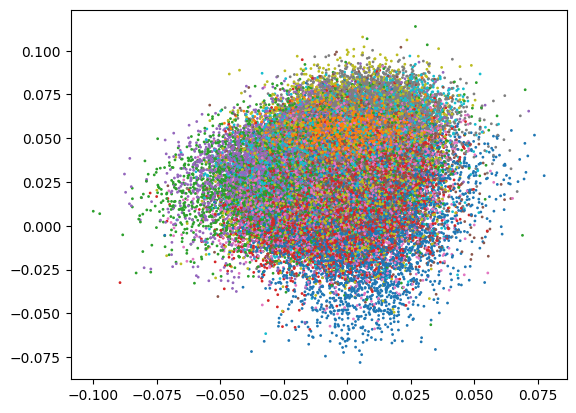

In [9]:
ae = AutoEncoder(z_dim).to(device)

images = []
labels = []
ae.eval()
with torch.no_grad():
    for x, label in dataloader:
        x = x.view(x.size(0), -1).to(device)
        z = ae.encoder(x)
        images.append(z.cpu())
        labels.append(label)
images = torch.cat(images, dim=0)
labels = torch.cat(labels, dim=0)
plt.scatter(images[:, 0], images[:, 1], c=labels, s=1, cmap='tab10');

できなかった。理由は正直よくわからない。

## 異常検知

入力と似た出力が行えるのは、入力が学習に使用したデータと同じ特徴を持っているときだけ。これを使って異常検知を行う。  
具体的な流れは以下

1. 正常なデータで学習させる
2. モデルに何らかのデータを入力する
3. モデルの出力と入力の誤差を計算する
4. 誤差が閾値を超えていたら異常と判定する

<br>

試しに、数字の0だけで学習させてみよう

In [10]:
def train(model, n_epochs, dataloader, critetion, optimizer):
    model.train()
    for epoch in range(n_epochs):
        for x, labels in dataloader:
            if 0 not in labels:
                continue
            x = x[labels == 0] # 0だけ使用
            optimizer.zero_grad()
            x = x.view(x.size(0), -1).to(device)
            y = model(x)
            loss = critetion(y, x)
            loss.backward()
            optimizer.step()
        print(f'{epoch+1:>3}epoch, loss:{loss.item()}')

In [11]:
z_dim = 10
ae = AutoEncoder(z_dim).to(device)
n_epochs = 5
critetion = nn.MSELoss()
optimizer = optim.Adam(ae.parameters(), lr=1e-3)
train(ae, n_epochs, dataloader, critetion, optimizer)

  1epoch, loss:0.02267812378704548
  2epoch, loss:0.018016869202256203
  3epoch, loss:0.01634824089705944
  4epoch, loss:0.014878230169415474
  5epoch, loss:0.019556188955903053


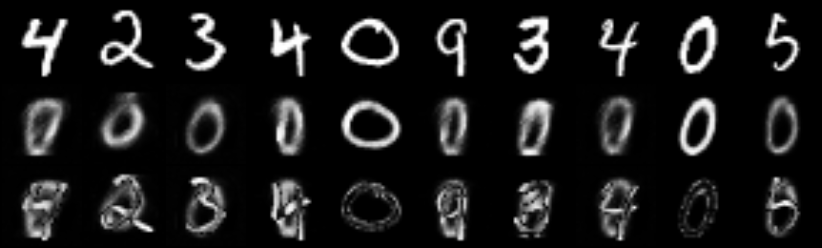

In [12]:
n_images = 10
width = 800

ae.eval()
with torch.no_grad():
    for x, labels in dataloader:
        if 0 not in labels[:n_images]:
            continue
        x = x[:n_images]
        x = x.view(x.size(0), -1).to(device)
        y = ae(x)
        break

x = x.view(n_images, 1, 28, 28).cpu()
y = y.view(n_images, 1, 28, 28).cpu()
diff = (x - y).abs()
diff = (diff - diff.min()) / (diff.max() - diff.min())
f = width // n_images
x = transforms.Resize((f))(x)
y = transforms.Resize((f))(y)
diff = transforms.Resize((f))(diff)
grid = torchvision.utils.make_grid(torch.cat([x, y, diff], dim=0), nrow=n_images)
img = transforms.functional.to_pil_image(grid)
display(img)

- 1段目：入力
- 2段目：出力
- 3段目：入力と出力の差

0以外の数値では上手く復元できていないのが分かる。というかどれも0っぽくなってしまっているね。

差の和を見てみる

In [13]:
print('label: diff')
for diff, label in zip(diff, labels):
    print(f'{label.item():>5}: {diff.sum().item():.3f} ')

label: diff
    4: 850.024 
    2: 807.794 
    3: 704.039 
    4: 816.046 
    0: 317.333 
    9: 629.774 
    3: 627.153 
    4: 637.774 
    0: 202.874 
    5: 491.317 


0が他と比べて小さいのが分かる